# Microchip Classification Training ipynb

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from datetime import timedelta, datetime
from PIL import Image
from sklearn.model_selection import KFold, train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

import tensorflow as tf
tf.__version__

Using TensorFlow backend.


'2.2.0'

## Data Preprocessing
To ensure all variety of each classes are considered, the images from reserved folders are also included, under the consent of Mr Fazle Rabbi. 30% of the whole dataset are randomly chosen and preserved as test/evaluation data in _test_image_ folder.

While loading the dataset, the minimum edge's length (both width and height considered) of the dataset are used as the size of the input image, which is 27 * 27 in this case. Despite the images provided are in colors, the training dataset is converted into grayscale image for ease of training.

In [2]:
# TO DO: REBUILD READ DATA
def readImg(path):
    return Image.open(path)

def resize_to_np(im, n):
    im = im.convert('L')
    im = im.resize((n,n))
    return np.array(im)/255.0 # normalisation

all_images = []
all_labels = []
labels_dict = {}

path = './Images/'

count = 0
min_size = 999
for label in os.listdir(path):
    second_path = path+str(label)+'/'
    for img_path in os.listdir(second_path):
        if not img_path.endswith('.jpg'):
            third_path = second_path + img_path + '/'
            for reserved in os.listdir(third_path):
                if reserved.endswith('.jpg'):
                    im = readImg(third_path+reserved)
                    min_size = min(min_size,min(im.size))
                    all_images.append(im)
                    all_labels.append(count)
            
        else:
            if img_path.endswith('.jpg'):
                im = readImg(second_path+img_path)
                min_size = min(min_size,min(im.size))
                all_images.append(im)
                all_labels.append(count)
    if (count < 3):
        labels_dict[count] = label
        count += 1
    elif (count == 3):
        labels_dict[count] = 'Unknown'

# Split data into 70/30
X_train, X_test, Y_train, Y_test = train_test_split(all_images, all_labels, test_size = 0.3, random_state=2)
print("x_train size",len(X_train))
print("x_test size",len(X_test))
print("y_train size",len(Y_train))
print("y_test size",len(Y_test))

if not os.path.exists('./test_images'):
    os.mkdir('./test_images')
    for _, label in labels_dict.items():
        os.mkdir('./test_images/'+label)
    for i in range(len(X_test)):
        X_test[i].save('./test_images/{}/{}.jpg'.format(labels_dict[Y_test[i]],i))

if not os.path.exists('./train_images'):
    os.mkdir('./train_images')
    for _, label in labels_dict.items():
        os.mkdir('./train_images/'+label)
    for i in range(len(X_train)):
        X_train[i].save('./train_images/{}/{}.jpg'.format(labels_dict[Y_train[i]],i))
        
print('Min: ',min_size)

temp = []
for i in range(len(X_train)):
    temp.append(resize_to_np(X_train[i], min_size))
X_train = temp
X_train = np.reshape(X_train,(-1,27,27,1))

# Label Encoding 
Y_train = np.reshape(Y_train, (-1,1))
Y_train = to_categorical(Y_train, num_classes = 4)

print('Y_train shape ',Y_train.shape)
print('X_train shape ',X_train.shape)

x_train size 1274
x_test size 546
y_train size 1274
y_test size 546
Min:  27
Y_train shape  (1274, 4)
X_train shape  (1274, 27, 27, 1)


## Model

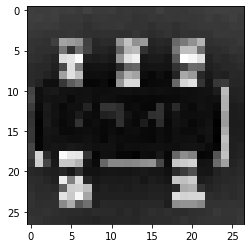

In [3]:
# Some examples
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

In [4]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.05, # Randomly zoom image 5%
        width_shift_range=0.05,  # randomly shift images horizontally 5%
        height_shift_range=0.05,  # randomly shift images vertically 5% 
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

class CNN():
    def __init__(self, batch_size, epochs):
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = Sequential()
        #
        self.model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                         activation ='relu', input_shape = (27,27,1)))
        self.model.add(MaxPool2D(pool_size=(2,2)))
        self.model.add(Dropout(0.25))
        #
        self.model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))
        self.model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
        self.model.add(Dropout(0.25))
        # fully connected
        self.model.add(Flatten())
        self.model.add(Dense(256, activation = "relu"))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(4, activation = "softmax"))
        # Define the optimizer
        optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
        # Compile the model
        self.model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
        
    def train(self,x_train,y_train,x_test,y_test):
        result = self.model.fit_generator(datagen.flow(x_train,y_train, batch_size= self.batch_size),
                                          epochs = self.epochs, 
                                          validation_data = (x_test,y_test), 
                                          steps_per_epoch=x_train.shape[0] // self.batch_size)
        return result
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def evaluate(self, test_images, test_labels):
        loss, acc = self.model.evaluate(test_images,  test_labels, verbose=2)
        return loss, acc
    
    def save(self, k, count):
        self.model.save('./models/model_{}_{}_{}_{}.h5'.format(k, self.batch_size, self.epochs, count+1))

Hyperparameter used in this model is:
* k fold of 10
* 15 epochs
* batch size of 16

In [5]:
# Fit the model
histories = []
models = []
n_split= 10
epochs = 15
batch_size = 16
count = 0
time_start = datetime.today()
for train_index,test_index in KFold(n_split).split(X_train):
    x_train,x_test=X_train[train_index],X_train[test_index]
    y_train,y_test=Y_train[train_index],Y_train[test_index]
    model = CNN(batch_size,epochs)
    result = model.train(x_train,y_train,x_test,y_test)
    model.save(n_split, count)
    models.append(model)
    histories.append(result)
    count+=1
time_end = datetime.today()

Epoch 1/15
71/71 [==============================] - 1s 18ms/step - loss: 1.1791 - accuracy: 0.5186 - val_loss: 0.9231 - val_accuracy: 0.7031
Epoch 2/15
71/71 [==============================] - 1s 11ms/step - loss: 0.8732 - accuracy: 0.6858 - val_loss: 0.6962 - val_accuracy: 0.7812
Epoch 3/15
71/71 [==============================] - 1s 14ms/step - loss: 0.6696 - accuracy: 0.7549 - val_loss: 0.5738 - val_accuracy: 0.8203
Epoch 4/15
71/71 [==============================] - 1s 13ms/step - loss: 0.5477 - accuracy: 0.8053 - val_loss: 0.4920 - val_accuracy: 0.8438
Epoch 5/15
71/71 [==============================] - 1s 11ms/step - loss: 0.4583 - accuracy: 0.8336 - val_loss: 0.3700 - val_accuracy: 0.8906
Epoch 6/15
71/71 [==============================] - 1s 10ms/step - loss: 0.4075 - accuracy: 0.8584 - val_loss: 0.3201 - val_accuracy: 0.8828
Epoch 7/15
71/71 [==============================] - 1s 9ms/step - loss: 0.3720 - accuracy: 0.8655 - val_loss: 0.2971 - val_accuracy: 0.8906
Epoch 8/15
71/

Epoch 14/15
71/71 [==============================] - 1s 10ms/step - loss: 0.2156 - accuracy: 0.9265 - val_loss: 0.1672 - val_accuracy: 0.9453
Epoch 15/15
71/71 [==============================] - 1s 10ms/step - loss: 0.2179 - accuracy: 0.9159 - val_loss: 0.1801 - val_accuracy: 0.9531
Epoch 1/15
71/71 [==============================] - 1s 12ms/step - loss: 1.1025 - accuracy: 0.5597 - val_loss: 0.8175 - val_accuracy: 0.6772
Epoch 2/15
71/71 [==============================] - 1s 10ms/step - loss: 0.6843 - accuracy: 0.7330 - val_loss: 0.5606 - val_accuracy: 0.8031
Epoch 3/15
71/71 [==============================] - 1s 11ms/step - loss: 0.5731 - accuracy: 0.7869 - val_loss: 0.5180 - val_accuracy: 0.7874
Epoch 4/15
71/71 [==============================] - 1s 11ms/step - loss: 0.4999 - accuracy: 0.8090 - val_loss: 0.4428 - val_accuracy: 0.8425
Epoch 5/15
71/71 [==============================] - 1s 11ms/step - loss: 0.4310 - accuracy: 0.8249 - val_loss: 0.4770 - val_accuracy: 0.8189
Epoch 6/15


Epoch 12/15
71/71 [==============================] - 1s 10ms/step - loss: 0.2561 - accuracy: 0.9063 - val_loss: 0.2007 - val_accuracy: 0.9055
Epoch 13/15
71/71 [==============================] - 1s 11ms/step - loss: 0.2241 - accuracy: 0.9231 - val_loss: 0.2381 - val_accuracy: 0.8740
Epoch 14/15
71/71 [==============================] - 1s 10ms/step - loss: 0.1988 - accuracy: 0.9355 - val_loss: 0.1840 - val_accuracy: 0.9055
Epoch 15/15
71/71 [==============================] - 1s 10ms/step - loss: 0.2132 - accuracy: 0.9222 - val_loss: 0.2380 - val_accuracy: 0.8976
Epoch 1/15
71/71 [==============================] - 1s 13ms/step - loss: 1.1263 - accuracy: 0.5517 - val_loss: 0.8438 - val_accuracy: 0.7638
Epoch 2/15
71/71 [==============================] - 1s 10ms/step - loss: 0.7553 - accuracy: 0.7392 - val_loss: 0.5933 - val_accuracy: 0.7874
Epoch 3/15
71/71 [==============================] - 1s 11ms/step - loss: 0.5900 - accuracy: 0.7798 - val_loss: 0.4035 - val_accuracy: 0.8504
Epoch 4/1

Check Time Used

In [6]:
time_delta = (time_end - time_start)
total_seconds = time_delta.total_seconds()
minutes = round(total_seconds/60)
print(minutes)

-2


Data Validation Check

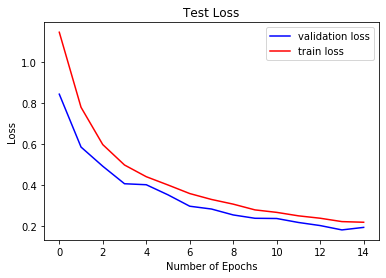

In [7]:
val_loss = []
loss = []
for history in histories:
    val_loss.append(history.history['val_loss'])
    loss.append(history.history['loss'])
val_loss = np.mean(np.reshape(val_loss,(n_split,epochs)), axis= 0)
loss = np.mean(np.reshape(loss,(n_split,epochs)), axis= 0)
plt.plot(val_loss, color='b', label="validation loss")
plt.plot(loss, color='r', label="train loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()